In [1]:
import os
import pandas as pd
import numpy as np
import openpyxl
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
'''Guia da numeração das colunas'''
# Questionario socio economico:
# Colunas 0 a 9

# teste de compulsão alimentar: N  a AC:
# Colunas 10 a 25

# Ortorexia:
# Colunas 26 a 40

'Guia da numeração das colunas'

In [3]:
def clean_weight(value):
    if isinstance(value, str):  # Se for string
        value = value.replace('kg', '').replace('Kg', '').replace('KG', '').strip()  # Remove 'kg'
        value = value.replace(',', '.')  # Troca vírgula por ponto
        try:
            return float(value)  # Tenta converter para float
        except ValueError:
            return None  # Retorna None se a conversão falhar
    elif isinstance(value, (int, float)):  # Se já for numérico
        return float(value)  # Retorna como float
    else:
        return None  # Para outros tipos (e.g., None)

def clean_height(value):
    if isinstance(value, str):  # Se for string
        value = value.replace('cm', '').replace('m', '').replace(',', '.').strip()  # Remove 'cm' e 'm', troca vírgula por ponto
        try:
            return float(value)  # Tenta converter para float
        except ValueError:
            return None  # Retorna None se a conversão falhar
    elif isinstance(value, (int, float)):  # Se já for numérico
        if isinstance(value, int) and value > 100:  # Se for inteiro e maior que 100
            return value / 100.0  # Divide por 100
        return float(value)  # Retorna como float
    else:
        return None  # Para outros tipos (e.g., None)

def check_compulsion(row):
    similar_questions = ['#2','#5', '#8', '#9','#10','#11','#12','#14','#15',]
    similar_answers = {1:0, 2:1, 3:2, 4:3}
    other_questions = {
        '#1': {1:0, 2:0, 3:1, 4:3},
        '#3': {1:0, 2:1, 3:3, 4:3},
        '#4': {1:0, 2:0, 3:0, 4:2},
        '#6': {1:0, 2:1, 3:3, 4:None},
        '#7': {1:0, 2:2, 3:3, 4:3},
        '#13': {1:0, 2:0, 3:2, 4:3},
        '#16': {1:0, 2:1, 3:2, 4:None},
    }
    total = 0
    answers_profile = []
    for column in row.columns:
        if column in similar_questions:
            user_answer = int(row[column].values[0])
            value = similar_answers[user_answer]
        else:
            user_answer = int(row[column].values[0])
            value = other_questions[column][user_answer]
        answers_profile.append([column, user_answer, value])
        total += value
    
    if total <= 17:
        diagnostic = 'TCAP ausente'
    elif total > 17 and total < 27:
        diagnostic = 'TCAP moderado'
    else:
        diagnostic = 'TCAP grave'

    return total, answers_profile, diagnostic

def check_ortorexia(row):
    similar_questions_01 = ['2','5','8','9']
    similar_answers_01 = {'Sempre': 4, 'Muitas vezes': 3, 'Algumas vezes': 2, 'Nunca': 1}

    similar_questions_02 = ['3','4','6','7','10','11','12','14','15',]
    similar_answers_02 = {'Sempre': 1, 'Muitas vezes': 2, 'Algumas vezes': 3, 'Nunca': 4}

    similar_questions_03 = ['1','13']
    similar_answers_03 = {'Sempre': 2, 'Muitas vezes': 4, 'Algumas vezes': 3, 'Nunca': 1}

    total = 0
    for column in row.columns:
        if column in similar_questions_01:
            user_answer = row[column].values[0]
            value = similar_answers_01[user_answer] 
        elif column in similar_questions_02:
            user_answer = row[column].values[0]
            value = similar_answers_02[user_answer] 
        elif column in similar_questions_03:
            user_answer = row[column].values[0]
            value = similar_answers_03[user_answer]
        total += value
    
    if total < 40:
        diagnostic = 'com ortorexia/comportamentos de risco'
    else:
        diagnostic = 'sem ortorexia/comportamentos de risco'

    return total, diagnostic

def check_nutrition_status(peso, altura):
    nutrition_status_cases = {
        'Magreza': 1,
        'Eutrófico': 2,
        'Sobrepeso': 3,
        'Obesidade': 4,
    }

    imc = peso/(altura)**2
    nutrition_status = ""
    if imc < 18.5:
       nutrition_status = 'Magreza'
    elif imc >= 18.5 and imc < 25:
       nutrition_status = 'Eutrófico' 
    elif imc >= 25 and imc < 30:
        nutrition_status = 'Sobrepeso'
    else:
        nutrition_status = 'Obesidade'
   
    return nutrition_status, nutrition_status_cases[nutrition_status]

In [4]:
file_path = "../data/filtered_data.csv"

if os.path.exists(file_path):
    filtered_df = pd.read_csv("../data/filtered_data.csv")
else:
    df = pd.read_excel("../data/raw_data.xlsx", engine='openpyxl')
    # Filtra se o consentimento foi dado e remvoe a coluna de consentimento (só por garantia)
    consentiment_column = df.columns[1]
    filtered_df = df[df[consentiment_column] == 'Li e concordo em participar da pesquisa.'].drop(['Carimbo de data/hora', 'Cidade e Estado:', consentiment_column], axis =1)
    
    # Renomeando algumas colunas:
    filtered_df.columns.values[0] = 'idade'
    filtered_df.columns.values[1] = 'peso'
    filtered_df.columns.values[2] = 'altura'
    filtered_df.columns.values[3] = 'sexo'
    filtered_df.columns.values[4] = 'gênero'
    filtered_df.columns.values[5] = 'etnia'
    q = 1
    for i in range(len(filtered_df.columns)):
        if i >= 26:

            filtered_df.columns.values[i] = str(q)
            q += 1

    # Tratando coluna da idade:    
    filtered_df['idade'] = filtered_df['idade'].apply(lambda x: ''.join(filter(str.isdigit, str(x))) if pd.notna(x) else x)
    filtered_df['idade'] = pd.to_numeric(filtered_df['idade'], errors='coerce').astype('Int64')

    # Tratando coluna peso:
    # Aplicar a função de limpeza
    filtered_df['peso'] = filtered_df['peso'].apply(clean_weight)

    # Tratando coluna altura:
    filtered_df['altura'] = filtered_df['altura'].apply(clean_height)

    # mapeando renda para renda_ref e removendo 
    category_mapping = {
        'Até 1 salário mínimo (Até R$ 1.612,26)': 1,
        'De 1 a 3 salários mínimos (De R$ 1.612,27 a R$ 4.836,78)': 2,
        'De 3 a 6 salários mínimos (De R$ 4.836,79 a R$ 9.673,56)': 3,
        'De 6 a 9 salários mínimos (De R$ 9.673,57 a R$ 14.510,34)': 4,
        'De 9 a 12 salários mínimos (De R$ 14.510,35 a R$ 19.347,12)': 5
    }

    filtered_df['renda_ref'] = filtered_df['Somando a sua renda com a renda das pessoas que moram com você, quanto é, aproximadamente, a renda familiar mensal? '].apply(lambda x: category_mapping.get(x, np.nan))
    filtered_df = filtered_df.drop(['Somando a sua renda com a renda das pessoas que moram com você, quanto é, aproximadamente, a renda familiar mensal? ', 'Quantas pessoas moram com você? (incluindo filhos, irmãos, parentes e amigos)'],axis=1)
    
    # mapeando insituição para inst_ref
    category_mapping = {
        'Pública': 1,
        'Privada': 2,
    }

    filtered_df['instituicao_ref'] = filtered_df['Qual categoria de faculdade você estuda?'].apply(lambda x: category_mapping.get(x, np.nan))
    filtered_df = filtered_df.drop(['Qual categoria de faculdade você estuda?','Trabalha ou já trabalhou durante a graduação?' ],axis=1)


    filtered_df.to_csv("../data/filtered_data.csv", index=False)


In [5]:
# Iterando o df linha a linha (usuario a usuario)
df = filtered_df.copy(deep=True)
size = df.shape[0]

new_df = pd.DataFrame()
for i in range(size):
    row =  filtered_df.iloc[i].to_frame().transpose()

    # Dados socio-econômicos
    row_social = row.iloc[:, 0:6]       # 0:6 includes columns from position 0 to 5
    
    idade = row_social['idade'].values[0]
    peso = row_social['peso'].values[0]
    altura = row_social['altura'].values[0]
    
    # Dados de Compulsão alimentar
    row_compulsion = row.iloc[:, 6:22]   # 6:22 includes columns from position 6 to 22
    row_compulsion = row_compulsion.apply(lambda col: col.str.replace(r'[^1234]', '', regex=True))
    total_compulsion, _, diagnostic = check_compulsion(row_compulsion)
    row['indice_compulsao'] = [total_compulsion]
    row['diagnostico_TCAP'] = [diagnostic]
    
    # Dados Ortorexia
    row_ortorexia = row.iloc[:, 22:37]   # 22:37 includes columns from position 23 to 36
    row_ortorexia.columns = row_ortorexia.columns.str.extract(r'(\d+)')[0]
    total_ortorexia, diagnostic = check_ortorexia(row_ortorexia)
    row['indice_ortorexia'] = [total_ortorexia]
    row['diagnostico_ortorexia'] = [diagnostic]

    # Dados estado nutricional:
    nutrition_status, nutrition_status_ref  = check_nutrition_status(peso, altura)
    row['estado_nutricional'] = [nutrition_status]
    row['estado_nutricional_ref'] = [nutrition_status_ref]
    new_df = pd.concat([new_df, row])

current_date = current_date = datetime.now().strftime("%d_%m_%y")
new_df.to_excel(f'../data/final_data_output_{current_date}.xlsx', index=False, engine='openpyxl')

2 - Análise estatística dos dados

In [6]:
# Informações da amostra:
sample_data_df = new_df.copy(deep=True)

# Convert columns to numeric
sample_data_df['idade'] = pd.to_numeric(sample_data_df['idade'].astype(str).str.strip(), errors='coerce')
sample_data_df['peso'] = pd.to_numeric(sample_data_df['peso'].astype(str).str.strip(), errors='coerce')

# Replace commas with dots in the altura column and convert to numeric
sample_data_df['altura'] = pd.to_numeric(sample_data_df['altura'].astype(str).str.replace(',', '.', regex=False).str.strip(), errors='coerce')

filter_df = sample_data_df[['idade', 'peso', 'altura']]

filter_df['idade'].plot(kind='box', figsize=(8, 6))
plt.title('Distribuição da Idade dos entrevistados')
plt.savefig("../../tcc-nutrition-course-facisa/reports/boxplots/idade.png")
plt.close()


filter_df['peso'].plot(kind='box', figsize=(8, 6))
plt.title('Distribuição da Peso dos entrevistados')
plt.savefig("../../tcc-nutrition-course-facisa/reports/boxplots/peso.png")
plt.close()


filter_df['altura'].plot(kind='box', figsize=(8, 6))
plt.title('Distribuição da Altura dos entrevistados')
plt.savefig("../../tcc-nutrition-course-facisa/reports/boxplots/altura.png")
plt.close()

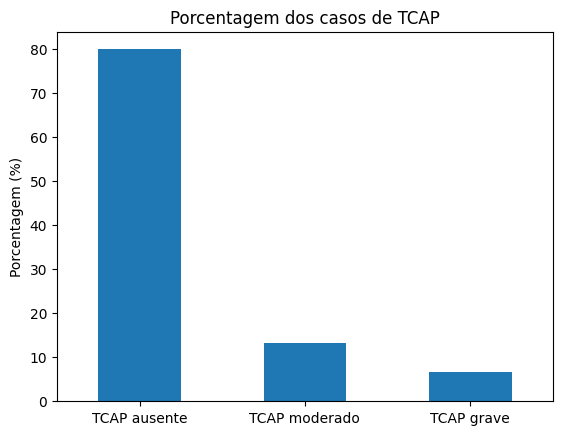

In [7]:
# Calculate percentage instead of total count
category_counts = sample_data_df['diagnostico_TCAP'].value_counts(normalize=True) * 100  # Normalize to get percentages
category_counts.plot(kind='bar')  # Use 'bar' for vertical bar plot

# Add labels and title
plt.title('Porcentagem dos casos de TCAP')
plt.ylabel('Porcentagem (%)')  # Update ylabel to indicate percentage
plt.xlabel('')  # Keep xlabel empty or modify as needed
plt.xticks(rotation=0)  # Keep x-axis labels horizontal

# Show the plot
plt.show()


In [8]:
# Distribuição do valor absoluto de TCAP
n = len(sample_data_df['indice_compulsao'])
bins = int(1 + np.log2(n))
# Plotando o histograma
ax = sample_data_df.indice_compulsao.plot(kind='hist', bins=bins, alpha=0.7, color='black')
plt.title("Distribuição do Índice de Compulsão Alimentar")
plt.ylabel('Frequência')
plt.xlabel('Índice de Compulsão')

# Obtendo os limites dos bins
bin_edges = np.histogram_bin_edges(sample_data_df['indice_compulsao'], bins=bins)
plt.savefig('../../tcc-nutrition-course-facisa/reports/histogramas/tcap.png')
plt.close()

# Distirbuição do valor absoluto de Ortorexia
n = len(sample_data_df['indice_ortorexia'])
bins = int(1 + np.log2(n))
# Plotando o histograma
ax = sample_data_df.indice_ortorexia.plot(kind='hist', bins=bins, alpha=0.7, color='black')
plt.title("Distribuição do Índice de Ortorexia")
plt.ylabel('Frequência')
plt.xlabel('Índice de Ortorexia')
# Obtendo os limites dos bins
bin_edges = np.histogram_bin_edges(sample_data_df['indice_ortorexia'], bins=bins)
plt.savefig('../../tcc-nutrition-course-facisa/reports/histogramas/orto.png')
plt.close()

# sample_data_df.boxplot(column='indice_ortorexia', color='black')

# # Adicionando título e rótulos
# plt.title("Box Plot do Índice de Ortorexia")
# plt.ylabel('Índice de Ortorexia')
# plt.grid(axis='y', alpha=0.75)
# plt.savefig('../../tcc-nutrition-course-facisa/reports/boxplots/ortorexia.png')
# plt.close()


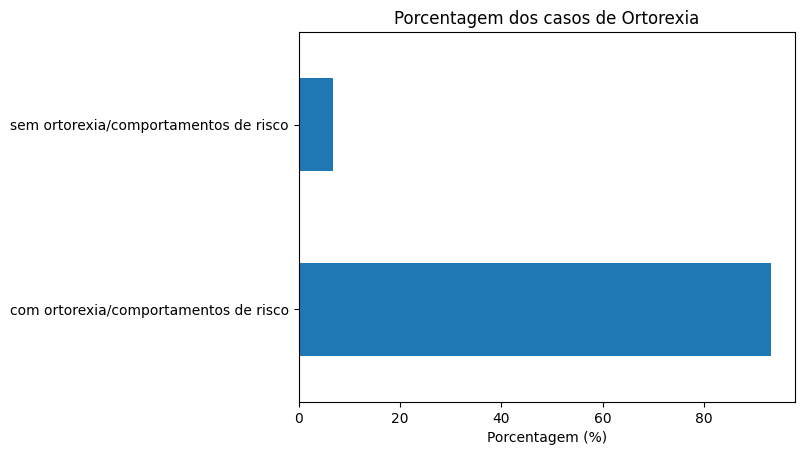

In [9]:
category_counts = sample_data_df['diagnostico_ortorexia'].value_counts(normalize=True) * 100  # Normalize to get percentages
category_counts.plot(kind='barh')  # Use 'barh' for a horizontal bar plot

# Add labels and title
plt.title('Porcentagem dos casos de Ortorexia')
plt.xlabel('Porcentagem (%)')  # Label for the percentage
plt.ylabel('')  # Hide ylabel if not needed

# Show the plot
plt.show()

Correlação entre estado nutricional e compulsão: positiva fraca (0.3483).


Text(0.5, 0, 'índice de ortorexia')

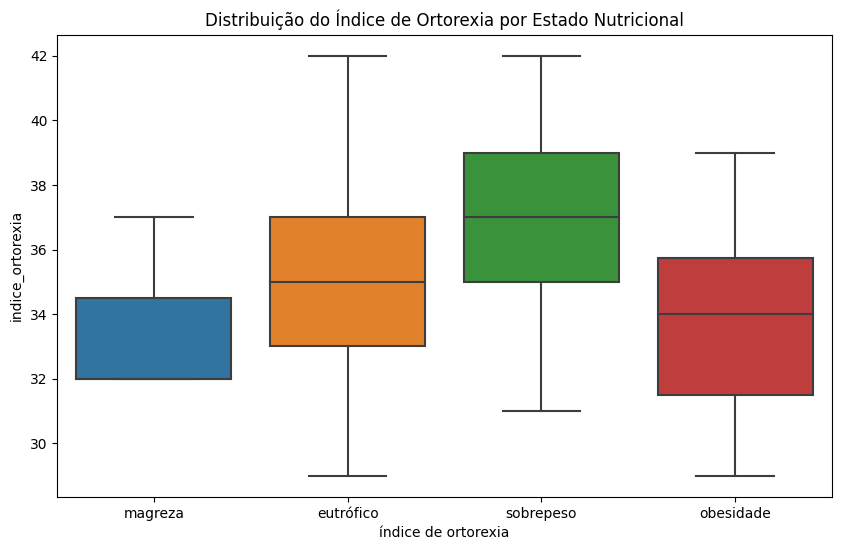

In [10]:
# Correlação TCAP x Estado nutricional
correlation_compulsao = np.round(new_df['estado_nutricional_ref'].corr(new_df['indice_compulsao'], method='spearman'),4)
corr = 0
if correlation_compulsao > 0.5:
    corr = 'positiva forte'
elif correlation_compulsao > 0 and correlation_compulsao <= 0.5:
    corr  =  'positiva fraca'
elif correlation_compulsao == 0:
    corr = 'não existe'
elif correlation_compulsao < 0 and correlation_compulsao >= -0.5:
    corr = 'negativa fraca'
else:
    corr = 'negativa fraca' 
print(f"Correlação entre estado nutricional e compulsão: {corr} ({correlation_compulsao}).")


# Criando um boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='estado_nutricional_ref', y='indice_ortorexia', data=new_df)

# Definindo o mapeamento para os rótulos do eixo x
category_labels = {1: 'magreza', 2: 'eutrófico', 3: 'sobrepeso', 4: 'obesidade'}

# Substituindo os rótulos do eixo x pelos nomes das categorias
ax.set_xticklabels([category_labels[i] for i in range(1, 5)])
plt.title('Distribuição do Índice de Ortorexia por Estado Nutricional')
plt.xlabel("estado nutricional")
plt.xlabel("índice de ortorexia")

In [11]:
# Correlação TCAP x Renda
new_df['renda_ref'] = pd.to_numeric(new_df['renda_ref'], errors='coerce')
correlation_compulsao = np.round(new_df['renda_ref'].corr(new_df['indice_compulsao'],method='spearman'),4)

corr = 0

if correlation_compulsao > 0.5:
    corr = 'positiva forte'
elif correlation_compulsao > 0 and correlation_compulsao <= 0.5:
    corr  =  'positiva fraca'
elif correlation_compulsao == 0:
    corr = 'não existe'
elif correlation_compulsao < 0 and correlation_compulsao >= -0.5:
    corr = 'negativa fraca'
else:
    corr = 'negativa fraca' 
print(f"Correlação entre renda e compulsão: {corr} ({correlation_compulsao}).")

# # Create a scatter plot with a regression line
# plt.figure(figsize=(8, 6))
# sns.regplot(x='renda_ref', y='indice_compulsao', data=new_df)

# # Show the plot
# plt.title('Correlação Renda X Índice de Compulsão Alimentar')
# plt.xlabel('renda')
# plt.ylabel('índice de compulsão')
# plt.savefig("../../tcc-nutrition-course-facisa/reports/correlations/renda_tcap.png")
# plt.close()

Correlação entre renda e compulsão: negativa fraca (-0.0717).


In [12]:
# Correlação TCAP x idade
new_df['idade'] = pd.to_numeric(new_df['idade'], errors='coerce')
correlation_compulsao = np.round(new_df['idade'].corr(new_df['indice_compulsao'],method='spearman'),4)

corr = 0

if correlation_compulsao > 0.5:
    corr = 'positiva forte'
elif correlation_compulsao > 0 and correlation_compulsao <= 0.5:
    corr  =  'positiva fraca'
elif correlation_compulsao == 0:
    corr = 'não existe'
elif correlation_compulsao < 0 and correlation_compulsao >= -0.5:
    corr = 'negativa fraca'
else:
    corr = 'negativa fraca' 
print(f"Correlação entre idade e compulsão: {corr} ({correlation_compulsao}).")

# Create a scatter plot with a regression line
plt.figure(figsize=(8, 6))
sns.regplot(x='idade', y='indice_compulsao', data=new_df)

# Show the plot
plt.title('Correlação Idade X Índice de Compulsão Alimentar')
plt.xlabel('idade')
plt.ylabel('índice de compulsão')
plt.savefig("../../tcc-nutrition-course-facisa/reports/correlations/idade_tcap.png")
plt.close()

Correlação entre idade e compulsão: negativa fraca (-0.1746).


In [13]:
# Correlação TCAP x Instituição (Pearson)
new_df['instituicao_ref'] = pd.to_numeric(new_df['instituicao_ref'], errors='coerce')
correlation_compulsao = np.round(new_df['instituicao_ref'].corr(new_df['indice_compulsao']),4)
corr = 0
if correlation_compulsao > 0.5:
    corr = 'positiva forte'
elif correlation_compulsao > 0 and correlation_compulsao <= 0.5:
    corr  =  'positiva fraca'
elif correlation_compulsao == 0:
    corr = 'não existe'
elif correlation_compulsao < 0 and correlation_compulsao >= -0.5:
    corr = 'negativa fraca'
else:
    corr = 'negativa fraca' 
print(f"Correlação entre instituição e compulsão: {corr} ({correlation_compulsao}).")

# # Create a scatter plot with a regression line
# plt.figure(figsize=(8, 6))
# sns.regplot(x='instituicao_ref', y='indice_compulsao', data=new_df)

# # Show the plot
# plt.title('Correlação Instituição X Índice de Compulsão Alimentar')
# plt.xlabel('instituicao_ref')
# plt.ylabel('índice de compulsão')
# plt.savefig("../../tcc-nutrition-course-facisa/reports/correlations/instituicao_tcap.png")
# plt.close()

Correlação entre instituição e compulsão: positiva fraca (0.2204).


In [14]:
# Correlação Orto x EN
correlation_ortorexia = np.round(new_df['estado_nutricional_ref'].corr(new_df['indice_ortorexia'],method='spearman'),4)

corr = 0
if correlation_ortorexia > 0.5:
    corr = 'positiva forte'
elif correlation_ortorexia > 0 and correlation_ortorexia <= 0.5:
    corr  =  'positiva fraca'
elif correlation_ortorexia == 0:
    corr = 'não existe'
elif correlation_ortorexia < 0 and correlation_ortorexia >= -0.5:
    corr = 'negativa fraca'
else:
    corr = 'negativa fraca' 
print(f"Correlação entre estado nutricional e ortorexia: {corr} ({correlation_ortorexia}).")

# Create a scatter plot with a regression line
plt.figure(figsize=(8, 6))
sns.regplot(x='estado_nutricional_ref', y='indice_ortorexia', data=new_df)

# Show the plot
plt.title('Correlação Estado Nutricional X Índice de Ortorexia')
plt.xlabel('estado nutricional')
plt.ylabel('índice de ortorexia')
plt.savefig("../../tcc-nutrition-course-facisa/reports/correlations/en_orto.png")
plt.close()

Correlação entre estado nutricional e ortorexia: positiva fraca (0.127).


In [15]:
# Correlação Orto x Renda
correlation_ortorexia = np.round(new_df['renda_ref'].corr(new_df['indice_ortorexia'],method='spearman'),4)

corr = 0
if correlation_ortorexia > 0.5:
    corr = 'positiva forte'
elif correlation_ortorexia > 0 and correlation_ortorexia <= 0.5:
    corr  =  'positiva fraca'
elif correlation_ortorexia == 0:
    corr = 'não existe'
elif correlation_ortorexia < 0 and correlation_ortorexia >= -0.5:
    corr = 'negativa fraca'
else:
    corr = 'negativa fraca' 
print(f"Correlação entre Renda e Ortorexia: {corr} ({correlation_ortorexia}).")

# # Create a scatter plot with a regression line
# plt.figure(figsize=(8, 6))
# sns.regplot(x='renda_ref', y='indice_ortorexia', data=new_df)

# # Show the plot
# plt.title('Correlação Renda X Índice de Ortorexia')
# plt.xlabel('renda')
# plt.ylabel('índice de ortorexia')
# plt.savefig("../../tcc-nutrition-course-facisa/reports/correlations/renda_orto.png")
# plt.close()

Correlação entre Renda e Ortorexia: positiva fraca (0.0992).


In [16]:
# Correlação Orto x Idade
correlation_ortorexia = np.round(new_df['idade'].corr(new_df['indice_ortorexia'],method='spearman'),4)

corr = 0
if correlation_ortorexia > 0.5:
    corr = 'positiva forte'
elif correlation_ortorexia > 0 and correlation_ortorexia <= 0.5:
    corr  =  'positiva fraca'
elif correlation_ortorexia == 0:
    corr = 'não existe'
elif correlation_ortorexia < 0 and correlation_ortorexia >= -0.5:
    corr = 'negativa fraca'
else:
    corr = 'negativa fraca' 
print(f"Correlação entre Idade e Ortorexia: {corr} ({correlation_ortorexia}).")

# Create a scatter plot with a regression line
plt.figure(figsize=(8, 6))
sns.regplot(x='idade', y='indice_ortorexia', data=new_df)

# Show the plot
plt.title('Correlação Idade X Índice de Ortorexia')
plt.xlabel('idade')
plt.ylabel('índice de ortorexia')
plt.savefig("../../tcc-nutrition-course-facisa/reports/correlations/idade_orto.png")
plt.close()

Correlação entre Idade e Ortorexia: negativa fraca (-0.1969).


In [17]:
# Correlação Orto x Instituição
correlation_ortorexia = np.round(new_df['instituicao_ref'].corr(new_df['indice_ortorexia']), 4)

corr = 0
if correlation_ortorexia > 0.5:
    corr = 'positiva forte'
elif correlation_ortorexia > 0 and correlation_ortorexia <= 0.5:
    corr  =  'positiva fraca'
elif correlation_ortorexia == 0:
    corr = 'não existe'
elif correlation_ortorexia < 0 and correlation_ortorexia >= -0.5:
    corr = 'negativa fraca'
else:
    corr = 'negativa fraca' 
print(f"Correlação entre Instituição e Ortorexia: {corr} ({correlation_ortorexia}).")

# # Create a scatter plot with a regression line
# plt.figure(figsize=(8, 6))
# sns.regplot(x='instituicao_ref', y='indice_ortorexia', data=new_df)

# # Show the plot
# plt.title('Correlação Instituição X Índice de Ortorexia')
# plt.xlabel('instituição')
# plt.ylabel('índice de ortorexia')
# plt.savefig("../../tcc-nutrition-course-facisa/reports/correlations/idade_orto.png")
# plt.close()

Correlação entre Instituição e Ortorexia: positiva fraca (0.1065).
